In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import h5py
import shutil
import matplotlib as mpl
from scipy.ndimage import gaussian_filter

In [2]:
def random_pert(thetafield, srfpertmag, zscl, zmax, modlvs):
    rng = np.random.default_rng()
    srfthetaperts = rng.normal(0, srfpertmag/3, np.shape(thetafield[0,:,:])) #Apply normally-distributed random-perturbations to the surface potential temp field
    #The reason for using srfpertmag/3 here is that 99.7% of randomly generated perturbations will be less than the value of srfpertmag. The higher values will be truncated below
    srfthetaperts = np.where(np.absolute(srfthetaperts)<srfpertmag, srfthetaperts, srfpertmag*np.sign(srfthetaperts)) #Truncate values over srfpertmag down to srfpertmag
    srfthetaperts = gaussian_filter(srfthetaperts, 1) #Smooth the surface theta field with a gaussian kernel
    thetaperts = np.ones_like(thetafield)*srfthetaperts[None,:,:] #Broadcast the 2D surface temperature perturbation array to 3D
    zmask = np.where(modlvs<=zmax, 1, 0)
    # print(zmask)
    thetaperts[2:,:,:] = thetaperts[1,:,:]*np.exp(-modlvs[2:,None,None]/zscl)*zmask[2:,None,None] #Exponentially decreasing temperature perturbations up to zmax
    thetafield_new = thetafield+thetaperts #Add temperature perturbations to pre-existing temperature field
    return thetafield_new

In [3]:
def get_zstar(topomin, dz0, dzrat, dzmax, nz):
    # print(zprops)
    z0star = topomin-dz0/2*dzrat**(-0.75) #Depth of first level (below ground, not used in analysis)
    zstarlvs = np.zeros(nz)
    zstarlvs[0] = z0star
    for zlev in range(1, nz):
        zstarlvs[zlev] = zstarlvs[zlev-1]+min(dz0*dzrat**(zlev-1.5), dzmax) #Get 
    return zstarlvs

In [ ]:
def get_gprops(headpath, ngrid):
    # Get grid properties from RAMS header file
    with open(headpath) as f:
        mylist = f.read().splitlines()
        nx = int(mylist[mylist.index('__nnxp')+ngrid+1]) #Number of x grid points on the grid
        ny = int(mylist[mylist.index('__nnyp')+ngrid+1]) #Number of y grid points on the grid
        nz = int(mylist[mylist.index('__nnzp')+ngrid+1]) #Number of z levels on the grid
        dx = float(mylist[mylist.index('__deltaxn')+ngrid+1]) #Grid spacing on the grid
        # dz0 = float(mylist[mylist.index('__deltazn')+ngrid+1]) #Not sure if we need this for anything
        zmix = mylist.index(f'__zmn{str(ngrid).zfill(2)}') 
        zmlvs = np.asarray([float(i) for i in mylist[zmix+2:zmix+nz+2]]) #Momentum (w) z-levels on the grid
        ztix = mylist.index(f'__ztn{str(ngrid).zfill(2)}')
        ztlvs = np.asarray([float(i) for i in mylist[ztix+2:ztix+nz+2]]) #Scalar z-levels on the grid
        dzmlvs = np.diff(zmlvs); dztlvs = np.diff(ztlvs) #Find cell vertical thicknesses
        gridprops = {"nx": nx, "ny": ny, "nz": nz, "dx": dx, "zstarlvs": ztlvs, "dztn": dztlvs, "wzstarlvs": zmlvs, "dzmn": dzmlvs}
#                 print(f'RAMS Z-levels: {i} {zm[i]:.1f} {zt[i]:.1f}')
    return gridprops

In [4]:
# tfnew = random_pert(thetafield, srfpertmag, zscl, zmax, modlvs)
# print(tfnew)

In [5]:
# testrandom_gaussian = np.random.default_rng().normal(loc = 0, scale = 0.3, size = (802, 802))
# print(testrandom_gaussian.min())
# print(tfnew.min(), tfnew.max())
# plt.figure()
# # tpmp = plt.contourf(tfnew[1,:,:], cmap = "RdBu_r", levels = np.linspace(-1*10**(-2), 1*10**(-2), 51))
# tpmp = plt.pcolormesh(tfnew[2,:,:], cmap = "RdBu_r", vmin = -1, vmax = 1)
# plt.colorbar(tpmp)

In [6]:
mpl.rcParams["axes.edgecolor"] = "whitesmoke"
mpl.rcParams["axes.facecolor"] = [0.5, 0.5, 0.5, 0]
mpl.rcParams["figure.facecolor"] = [0.5, 0.5, 0.5, 0]
mpl.rcParams["figure.edgecolor"] = "whitesmoke"
mpl.rcParams["text.color"] = "whitesmoke"
mpl.rcParams["axes.labelcolor"] = "whitesmoke"
mpl.rcParams["ytick.color"] = "whitesmoke"
mpl.rcParams["xtick.color"] = "whitesmoke"

In [ ]:
# ndvisafe = xr.open_dataset("/moonbow/ascheb/escape/idealized/exp1/ndhsafe.h5");# print(ndvisafe)
# plt.figure()
# ndvmp = plt.contourf(ndvisafe["VEG_NDVIF"][1,:,:], cmap = "BrBG", levels = np.arange(0, 1, 0.05))
# plt.colorbar(ndvmp)

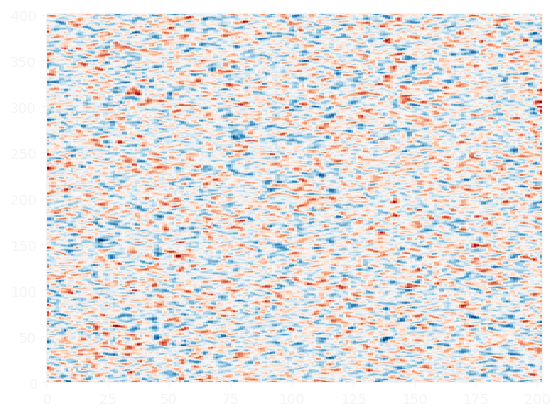

In [16]:
plt.figure()
with xr.open_dataset("/moonbow/ascheb/escape/idealized/exp1_coarse4/rams_output/a-A-2022-06-21-060000-g1.h5") as sfcfile:
    # plt.pcolormesh(sfcfile["PATCH_AREA"][1,:,:], vmin = 0, vmax = 1)
    plt.pcolormesh(sfcfile["THETA"][1,:,:], cmap = "RdBu_r")
# plt.close()
sfcfile.close(); del sfcfile

Run for 1 minute to get initial analysis file

In [12]:
topo = xr.open_dataset("/moonbow/ascheb/escape/idealized/exp1_coarse4/toph-S-g1.h5")["TOPT"]; topomin = topo.min(); topo.close(); 
dz0 = 30; dzrat = 1.05; dzmax = 300; nz = 105
print(get_zstar(topomin, dz0, dzrat, dzmax, nz))
modlvs = get_zstar(topomin, dz0, dzrat, dzmax, nz)
srfpertmag = 1; zscl = 300; zmax = 1000

[-1.44610319e+01  1.48159703e+01  4.55568226e+01  7.78347175e+01
  1.11726507e+02  1.47312886e+02  1.84678584e+02  2.23912567e+02
  2.65108250e+02  3.08363716e+02  3.53781955e+02  4.01471107e+02
  4.51544716e+02  5.04122006e+02  5.59328160e+02  6.17294621e+02
  6.78159406e+02  7.42067430e+02  8.09170856e+02  8.79629452e+02
  9.53610979e+02  1.03129158e+03  1.11285621e+03  1.19849908e+03
  1.28842409e+03  1.38284534e+03  1.48198767e+03  1.58608710e+03
  1.69539151e+03  1.81016114e+03  1.93066925e+03  2.05720277e+03
  2.19006296e+03  2.32956616e+03  2.47604452e+03  2.62984680e+03
  2.79133920e+03  2.96090621e+03  3.13895158e+03  3.32589921e+03
  3.52219422e+03  3.72830399e+03  3.94471924e+03  4.17195526e+03
  4.41055307e+03  4.66108078e+03  4.92413487e+03  5.20034167e+03
  5.49035881e+03  5.79035881e+03  6.09035881e+03  6.39035881e+03
  6.69035881e+03  6.99035881e+03  7.29035881e+03  7.59035881e+03
  7.89035881e+03  8.19035881e+03  8.49035881e+03  8.79035881e+03
  9.09035881e+03  9.39035

Add Perturbations to Initial Theta Field - Now do History Restart!!

In [13]:
srfprepath_coarse = "/moonbow/ascheb/escape/idealized/exp1_coarse4/"
inittime = "2022-06-21-060000"
afile = h5py.File(f"{srfprepath_coarse}rams_output/a-A-{inittime}-g1.h5", "r+")
thetacopy = np.copy(afile["THETA"])
newtheta = random_pert(thetacopy, srfpertmag, zscl, zmax, modlvs)
afile["THETA"][:,:,:] = newtheta
afile.close();

In [ ]:
fig, ax11 = plt.subplots(1,1, figsize = (15,15))
coarsesrf = xr.open_dataset(f"{srfprepath_coarse}sfch-S-g1.h5")
# ax11.contourf(coarsesrf["LEAF_CLASS"][1,:,:].where(coarsesrf["PATCH_AREA"][1,:,:]== 1), colors = "gold")
# ax11.contourf(coarsesrf["PATCH_AREA"][0,:,:].where(coarsesrf["PATCH_AREA"][0,:,:]==1), colors = "navy")
# # sfcds["PATCH_AREA"][1,:,:].plot()
# ax11.annotate("OCEAN", (401, 100), color = "white", fontfamily = "fantasy", fontstyle = "oblique", fontsize = 100, horizontalalignment = "center", verticalalignment = "center")
# ax11.annotate("PASTURE", (401, 500), color = "black", fontfamily = "fantasy", fontstyle = "oblique", fontsize = 100, horizontalalignment = "center", verticalalignment = "center")
# ax11.set_title("Uniform Pasture Land Domain", fontsize = 20, fontweight = "demibold")
ax11.pcolormesh(coarsesrf["PATCH_AREA"].sum(dim = "phony_dim_0"), vmin = 0, vmax = 1)
coarsesrf.close();

Experiment 1 Setup - Horizontal Ocean South of Uniform Pasture Land

In [ ]:
srfprepath = "/moonbow/ascheb/escape/idealized/exp1/"

shutil.copyfile(f"{srfprepath}ndhsafe.h5", f"{srfprepath}ndh-N-2022-06-21-000000-g1.h5")
shutil.copyfile(f"{srfprepath}sfchsafe.h5", f"{srfprepath}sfch-S-g1.h5")
shutil.copyfile(f"{srfprepath}tophsafe.h5", f"{srfprepath}toph-S-g1.h5")
shutil.copyfile(f"{srfprepath}ssthsafe.h5", f"{srfprepath}ssth-W-2022-06-21-000000-g1.h5")

In [ ]:
oceanbounds = slice(0,201); #Min/max y values occupied by water
sfcfile = h5py.File(f"{srfprepath}sfch-S-g1.h5", "r+")
ndvfile = h5py.File(f"{srfprepath}ndh-N-2022-06-21-000000-g1.h5")
tophfile = h5py.File(f"{srfprepath}toph-S-g1.h5")
ssthfile = h5py.File(f"{srfprepath}ssth-W-2022-06-21-000000-g1.h5")

sfcfile["PATCH_AREA"][0,oceanbounds,:] = 1
sfcfile["PATCH_AREA"][1,oceanbounds,:] = 0
sfcfile["LEAF_CLASS"][1,:,:] = 15
sfcfile.close(); ndvfile.close(); tophfile.close(); ssthfile.close();

Experiment 2 Setup - Horizontal Ocean South of Pasture Land and Coniferous Forest

In [ ]:
srfprepath = "/moonbow/ascheb/escape/idealized/exp1/"
srfprepath2 = "/moonbow/ascheb/escape/idealized/exp2/"

shutil.copyfile(f"{srfprepath}ndhsafe.h5", f"{srfprepath2}ndh-N-2022-06-21-000000-g1.h5")
shutil.copyfile(f"{srfprepath}sfchsafe.h5", f"{srfprepath2}sfch-S-g1.h5")
shutil.copyfile(f"{srfprepath}tophsafe.h5", f"{srfprepath2}toph-S-g1.h5")
shutil.copyfile(f"{srfprepath}ssthsafe.h5", f"{srfprepath2}ssth-W-2022-06-21-000000-g1.h5")

oceanbounds = slice(0,201); #Min/max y values occupied by water
pasturebnds_0 = slice(0,201); pasturebnds_1 = slice(601, 802); forestbnds = slice(201,601)
sfcfile = h5py.File(f"{srfprepath2}sfch-S-g1.h5", "r+")
ndvfile = h5py.File(f"{srfprepath2}ndh-N-2022-06-21-000000-g1.h5", "r+")
tophfile = h5py.File(f"{srfprepath2}toph-S-g1.h5", "r+")
ssthfile = h5py.File(f"{srfprepath2}ssth-W-2022-06-21-000000-g1.h5", "r+")

sfcfile["PATCH_AREA"][0,oceanbounds,:] = 1
sfcfile["PATCH_AREA"][1,oceanbounds,:] = 0
ndvfile["VEG_NDVIF"][1,:,forestbnds] = 0.65
sfcfile["LEAF_CLASS"][1,:,pasturebnds_0] = 15; sfcfile["LEAF_CLASS"][1,:,pasturebnds_1] = 15
sfcfile["LEAF_CLASS"][1,:,forestbnds] = 4 #Need to figure out if this an acceptable way to do this with zonally periodic boundaries (essentially tiling pasture and forest next to each other)

sfcfile.close(); ndvfile.close(); tophfile.close(); ssthfile.close();

Experiment 3 Setup - Horizontal Ocean South of Uniform Coniferous Forest

In [ ]:
srfprepath = "/moonbow/ascheb/escape/idealized/exp1/"
srfprepath3 = "/moonbow/ascheb/escape/idealized/exp3/"

shutil.copyfile(f"{srfprepath}ndhsafe.h5", f"{srfprepath3}ndh-N-2022-06-21-000000-g1.h5")
shutil.copyfile(f"{srfprepath}sfchsafe.h5", f"{srfprepath3}sfch-S-g1.h5")
shutil.copyfile(f"{srfprepath}tophsafe.h5", f"{srfprepath3}toph-S-g1.h5")
shutil.copyfile(f"{srfprepath}ssthsafe.h5", f"{srfprepath3}ssth-W-2022-06-21-000000-g1.h5")

oceanbounds = slice(0,201); #Min/max y values occupied by water
sfcfile = h5py.File(f"{srfprepath3}sfch-S-g1.h5", "r+")
ndvfile = h5py.File(f"{srfprepath3}ndh-N-2022-06-21-000000-g1.h5", "r+")
tophfile = h5py.File(f"{srfprepath3}toph-S-g1.h5", "r+")
ssthfile = h5py.File(f"{srfprepath3}ssth-W-2022-06-21-000000-g1.h5", "r+")

sfcfile["PATCH_AREA"][0,oceanbounds,:] = 1
sfcfile["PATCH_AREA"][1,oceanbounds,:] = 0
ndvfile["VEG_NDVIF"][1,:,:] = 0.65
sfcfile["LEAF_CLASS"][1,:,:] = 4

sfcfile.close(); ndvfile.close(); tophfile.close(); ssthfile.close();

Experiment 4 Setup - Horizontal Ocean South of City and Coniferous Forest

In [ ]:
srfprepath = "/moonbow/ascheb/escape/idealized/exp1/"
srfprepath4 = "/moonbow/ascheb/escape/idealized/exp4/"

shutil.copyfile(f"{srfprepath}ndhsafe.h5", f"{srfprepath4}ndh-N-2022-06-21-000000-g1.h5")
shutil.copyfile(f"{srfprepath}sfchsafe.h5", f"{srfprepath4}sfch-S-g1.h5")
shutil.copyfile(f"{srfprepath}tophsafe.h5", f"{srfprepath4}toph-S-g1.h5")
shutil.copyfile(f"{srfprepath}ssthsafe.h5", f"{srfprepath4}ssth-W-2022-06-21-000000-g1.h5")

oceanbounds = slice(0,201); #Min/max y values occupied by water
urbanbnds_0 = slice(0,201); urbanbnds_1 = slice(601, 802); forestbnds = slice(201,601)
sfcfile = h5py.File(f"{srfprepath4}sfch-S-g1.h5", "r+")
ndvfile = h5py.File(f"{srfprepath4}ndh-N-2022-06-21-000000-g1.h5", "r+")
tophfile = h5py.File(f"{srfprepath4}toph-S-g1.h5", "r+")
ssthfile = h5py.File(f"{srfprepath4}ssth-W-2022-06-21-000000-g1.h5", "r+")

sfcfile["PATCH_AREA"][0,oceanbounds,:] = 1
sfcfile["PATCH_AREA"][1,oceanbounds,:] = 0
ndvfile["VEG_NDVIF"][1,:,forestbnds] = 0.65
sfcfile["LEAF_CLASS"][1,:,urbanbnds_0] = 19; sfcfile["LEAF_CLASS"][1,:,urbanbnds_1] = 19
sfcfile["LEAF_CLASS"][1,:,forestbnds] = 4 #Need to figure out if this an acceptable way to do this with zonally periodic boundaries (essentially tiling pasture and forest next to each other)

sfcfile.close(); ndvfile.close(); tophfile.close(); ssthfile.close();

In [ ]:
plt.figure()
print(np.unique(sfcds_2["LEAF_CLASS"][1,:,:]))

In [ ]:
sfcds_1 = xr.open_dataset(f"{srfprepath}sfch-S-g1.h5"); sfcds_2 = xr.open_dataset(f"{srfprepath2}sfch-S-g1.h5")
sfcds_3 = xr.open_dataset(f"{srfprepath3}sfch-S-g1.h5"); sfcds_4 = xr.open_dataset(f"{srfprepath4}sfch-S-g1.h5")
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2, 2, figsize = (30, 30))
ax11.contourf(sfcds_1["LEAF_CLASS"][1,:,:].where(sfcds_1["PATCH_AREA"][1,:,:]== 1), colors = "gold")
ax11.contourf(sfcds_1["PATCH_AREA"][0,:,:].where(sfcds_1["PATCH_AREA"][0,:,:]==1), colors = "navy")
# sfcds["PATCH_AREA"][1,:,:].plot()
ax11.annotate("OCEAN", (401, 100), color = "white", fontfamily = "fantasy", fontstyle = "oblique", fontsize = 100, horizontalalignment = "center", verticalalignment = "center")
ax11.annotate("PASTURE", (401, 500), color = "black", fontfamily = "fantasy", fontstyle = "oblique", fontsize = 100, horizontalalignment = "center", verticalalignment = "center")
ax11.set_title("Uniform Pasture Land Domain", fontsize = 20, fontweight = "demibold")
ax12.contourf(sfcds_3["LEAF_CLASS"][1,:,:].where(sfcds_1["PATCH_AREA"][1,:,:]==1), colors = "darkgreen")
ax12.contourf(sfcds_3["PATCH_AREA"][0,:,:].where(sfcds_3["PATCH_AREA"][0,:,:]==1), colors = "navy")
ax12.annotate("OCEAN", (401, 100), color = "white", fontfamily = "fantasy", fontstyle = "oblique", fontsize = 100, horizontalalignment = "center", verticalalignment = "center")
ax12.annotate("CONIFEROUS \n FOREST", (401, 500), color = "white", fontfamily = "fantasy", fontstyle = "oblique", fontsize = 100, horizontalalignment = "center", verticalalignment = "center")
ax12.set_title("Uniform Coniferous Forest Land Domain", fontsize = 20, fontweight = "demibold")
ax21.contourf(sfcds_2["LEAF_CLASS"][1,:,:].where(sfcds_2["PATCH_AREA"][1,:,:]==1), colors = ["darkgreen", "gold"])
ax21.contourf(sfcds_2["PATCH_AREA"][0,:,:].where(sfcds_2["PATCH_AREA"][0,:,:]==1), colors = "navy")
ax21.annotate("OCEAN", (401, 100), color = "white", fontfamily = "fantasy", fontstyle = "oblique", fontsize = 100, horizontalalignment = "center", verticalalignment = "center")
ax21.annotate("PASTURE", (101, 500), color = "black", fontfamily = "fantasy", fontstyle = "oblique", fontsize = 50, horizontalalignment = "center", verticalalignment = "center")
ax21.annotate("PASTURE", (701, 500), color = "black", fontfamily = "fantasy", fontstyle = "oblique", fontsize = 50, horizontalalignment = "center", verticalalignment = "center")
ax21.annotate("CONIFEROUS \n FOREST", (401, 500), color = "white", fontfamily = "fantasy", fontstyle = "oblique", fontsize = 50, horizontalalignment = "center", verticalalignment = "center")
ax21.set_title("Forest/Pasture Land Domain", fontsize = 20, fontweight = "demibold")
ax22.contourf(sfcds_4["LEAF_CLASS"][1,:,:].where(sfcds_2["PATCH_AREA"][1,:,:]==1), colors = ["darkgreen", "darkred"])
ax22.contourf(sfcds_4["PATCH_AREA"][0,:,:].where(sfcds_2["PATCH_AREA"][0,:,:]==1), colors = "navy")
ax22.annotate("OCEAN", (401, 100), color = "white", fontfamily = "fantasy", fontstyle = "oblique", fontsize = 100, horizontalalignment = "center", verticalalignment = "center")
ax22.annotate("URBAN", (101, 500), color = "white", fontfamily = "fantasy", fontstyle = "oblique", fontsize = 50, horizontalalignment = "center", verticalalignment = "center")
ax22.annotate("URBAN", (701, 500), color = "white", fontfamily = "fantasy", fontstyle = "oblique", fontsize = 50, horizontalalignment = "center", verticalalignment = "center")
ax22.annotate("CONIFEROUS \n FOREST", (401, 500), color = "white", fontfamily = "fantasy", fontstyle = "oblique", fontsize = 50, horizontalalignment = "center", verticalalignment = "center")
ax22.set_title("Forest/Urban Land Domain", fontsize = 20, fontweight = "demibold")
fig.savefig("/sumatra/ascheb/escape/python/idealizedland.png")

In [ ]:
print(np.shape(ndvisafe["VEG_NDVIF"]))

In [ ]:
sfcds_1.close(); sfcds_2.close();